In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR

from tslearn.datasets import UCR_UEA_datasets

ucr = UCR_UEA_datasets(use_cache=False)   # force fresh download once
train_x, train_y, test_x, test_y = ucr.load_dataset("FordA")





In [7]:

enc = OneHotEncoder(sparse_output=False)
train_y_oh = enc.fit_transform(train_y.reshape(-1, 1))
test_y_oh = enc.transform(test_y.reshape(-1, 1))

train_x shape: (3601, 500, 1)
train_y shape: (3601,)
classes: [-1  1]


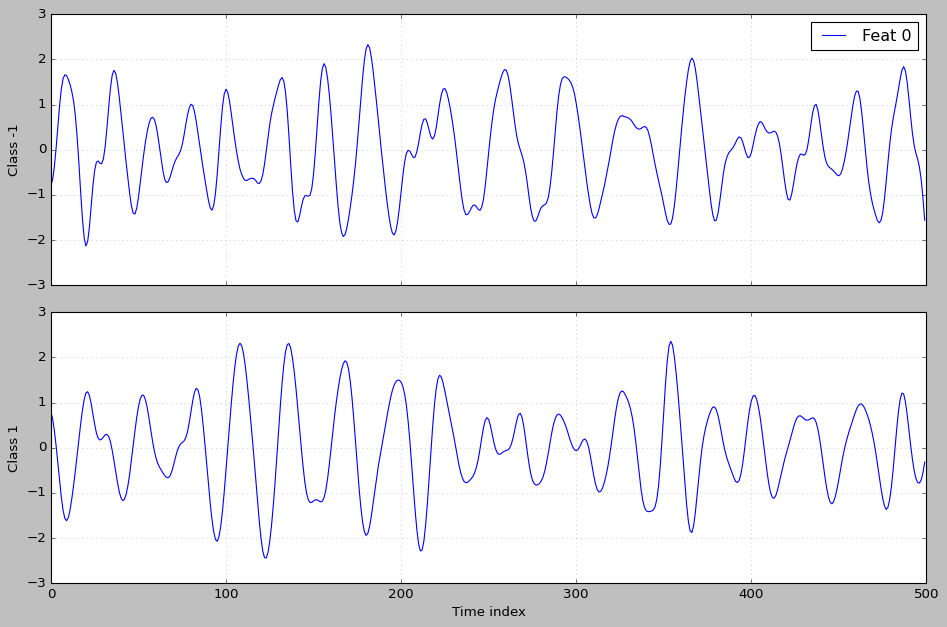

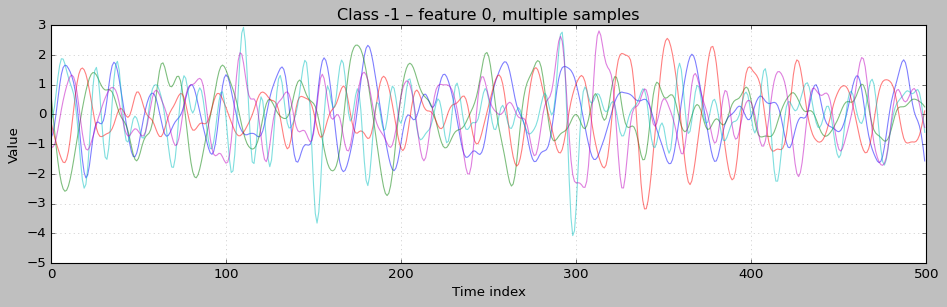

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Basic info
print("train_x shape:", train_x.shape)   # (n_samples, T) or (n_samples, T, D)
print("train_y shape:", train_y.shape)
classes = np.unique(train_y)
print("classes:", classes)

# Infer dims
if train_x.ndim == 3:
    _, T, n_dims = train_x.shape
elif train_x.ndim == 2:
    _, T = train_x.shape
    n_dims = 1
    train_x = train_x[:, :, None]  # (N, T, 1)
else:
    raise ValueError("Unexpected train_x shape")

# ---- 1) One example per class, all features ----
fig, axes = plt.subplots(len(classes), 1, figsize=(12, 8), sharex=True)

for row, c in enumerate(classes):
    idx = np.where(train_y == c)[0][0]
    ts = train_x[idx]          # (T, D)
    axes[row].plot(ts)
    axes[row].set_ylabel(f"Class {c}")
    axes[row].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time index")
axes[0].legend([f"Feat {d}" for d in range(n_dims)], loc="upper right")
plt.tight_layout()
plt.show()

# ---- 2) Several samples of a single class (e.g., class 0) ----
cls = classes[0]
idxs = np.where(train_y == cls)[0][:5]   # first 5 samples of that class

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for idx in idxs:
    ts = train_x[idx, :, 0]              # feature 0 only
    ax.plot(ts, alpha=0.5)
ax.set_title(f"Class {cls} – feature 0, multiple samples")
ax.set_xlabel("Time index")
ax.set_ylabel("Value")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:

n_timestamps = train_x.shape[1]
n_dims = train_x.shape[2]
n_classes = train_y_oh.shape[1]

# 2) Simple Conv1D model
inputs = keras.Input(shape=(n_timestamps, n_dims))
x = layers.Conv1D(32, 7, padding="same", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_x,
    train_y_oh,
    epochs=20,
    batch_size=32,
    validation_data=(test_x, test_y_oh),
    verbose=2,
)

Epoch 1/20
113/113 - 2s - loss: 0.4532 - accuracy: 0.7756 - val_loss: 0.6992 - val_accuracy: 0.5159 - 2s/epoch - 22ms/step
Epoch 2/20
113/113 - 2s - loss: 0.3509 - accuracy: 0.8467 - val_loss: 0.7100 - val_accuracy: 0.5159 - 2s/epoch - 18ms/step
Epoch 3/20
113/113 - 2s - loss: 0.3097 - accuracy: 0.8623 - val_loss: 0.6459 - val_accuracy: 0.5326 - 2s/epoch - 18ms/step
Epoch 4/20
113/113 - 2s - loss: 0.2914 - accuracy: 0.8745 - val_loss: 0.6277 - val_accuracy: 0.6106 - 2s/epoch - 18ms/step
Epoch 5/20
113/113 - 2s - loss: 0.2757 - accuracy: 0.8778 - val_loss: 0.3635 - val_accuracy: 0.8258 - 2s/epoch - 19ms/step
Epoch 6/20
113/113 - 2s - loss: 0.2768 - accuracy: 0.8870 - val_loss: 0.2700 - val_accuracy: 0.8902 - 2s/epoch - 19ms/step
Epoch 7/20
113/113 - 2s - loss: 0.2659 - accuracy: 0.8839 - val_loss: 0.3015 - val_accuracy: 0.8682 - 2s/epoch - 18ms/step
Epoch 8/20
113/113 - 2s - loss: 0.2608 - accuracy: 0.8853 - val_loss: 0.2350 - val_accuracy: 0.8977 - 2s/epoch - 18ms/step
Epoch 9/20
113/1

In [20]:
test_x.shape

(1320, 500, 1)

Mode in TF Saliency time
True
time mode


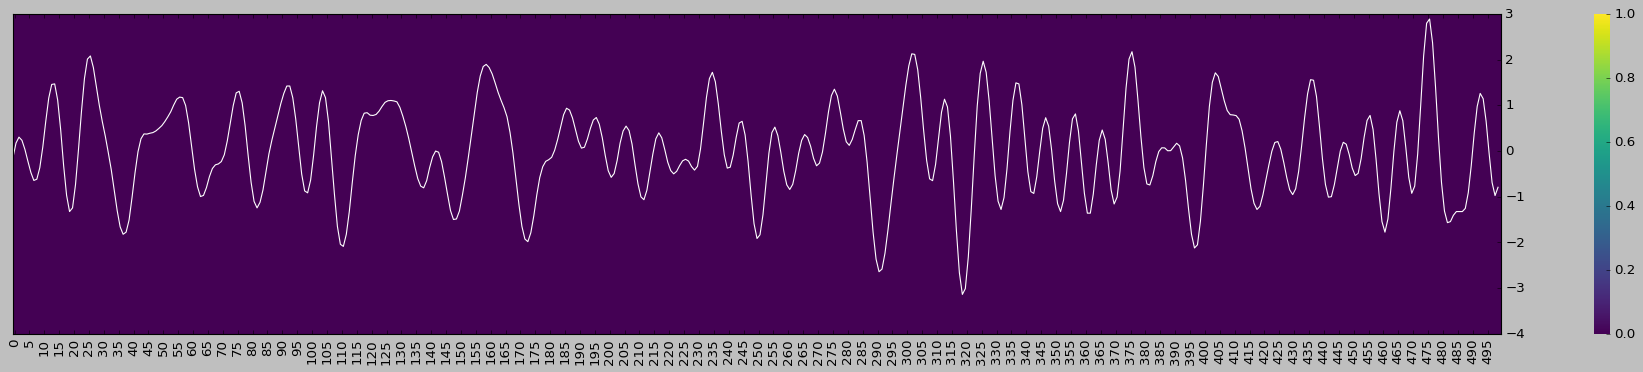

True
time mode


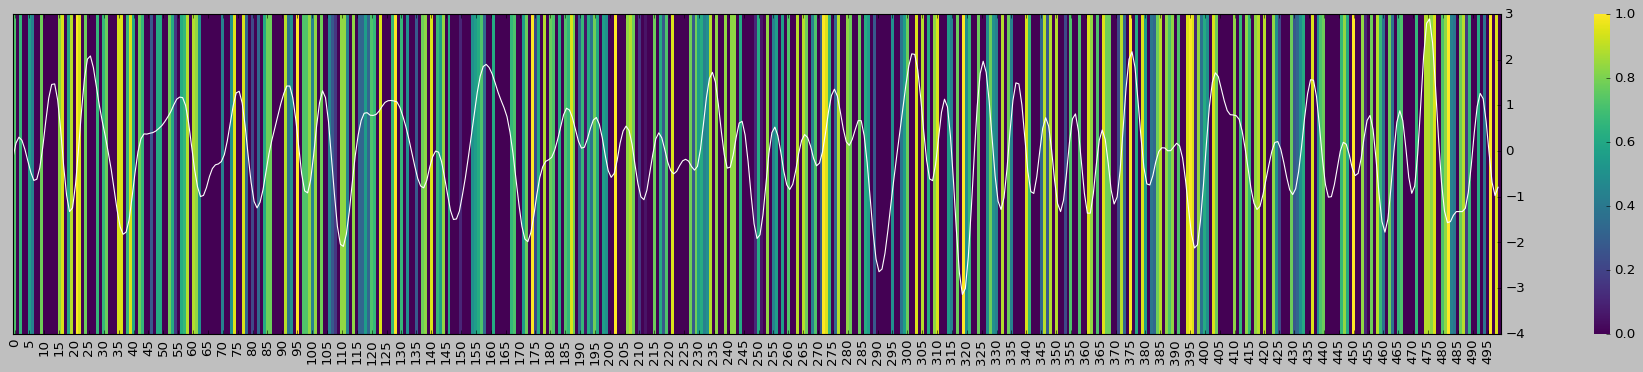

In [26]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
idx = 0
int_mod=TSR(model, train_x.shape[-2],train_x.shape[-1], method='SG',mode='time')
item= np.array([test_x[idx,:,:]])

for c in range(n_classes):
    exp=int_mod.explain(item,labels=c,TSR =True)

    %matplotlib inline  
    int_mod.plot(np.array([test_x[idx,:,:]]),exp, figsize=(30, 5))

Mode in TF Saliency time
True
time mode


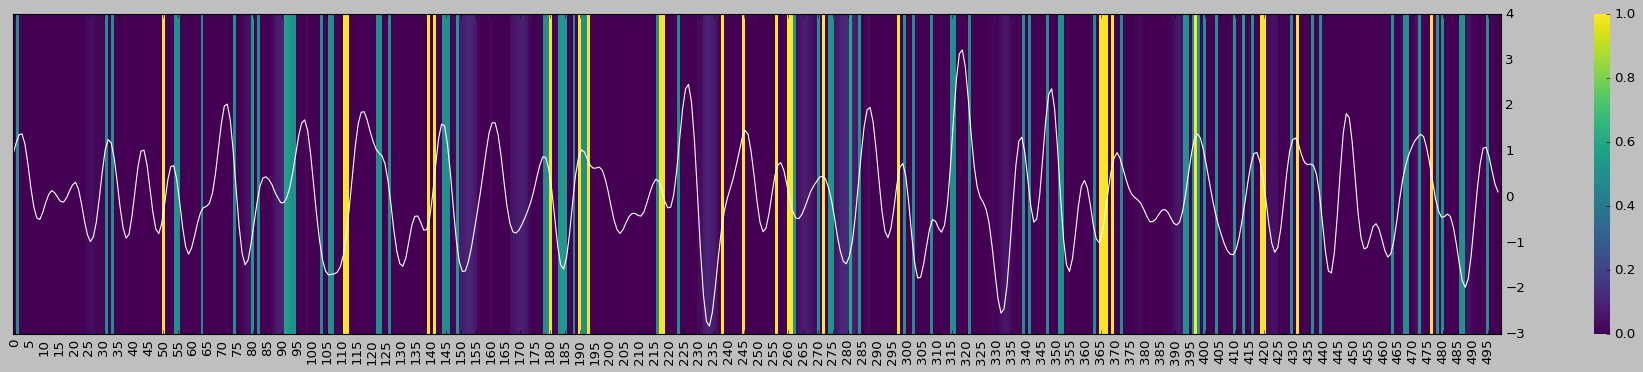

In [30]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
idx = 323
int_mod=TSR(model, train_x.shape[-2],train_x.shape[-1], method='GRAD',mode='time')
item= np.array([test_x[idx,:,:]])

exp=int_mod.explain(item,labels=1,TSR =True)

%matplotlib inline  
int_mod.plot(np.array([test_x[idx,:,:]]),exp, figsize=(30, 5))